In [1]:
import os
from pathlib import Path
import math

import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

In [2]:
base_dir = Path("/Users/szhan/Projects/tsimpute/results/")
in_ts_default_csv_file = base_dir / "chr20_p.default.imputation.csv.gz"
in_samples_matched_csv_file = base_dir / "chr20_p.samples_matched.imputation.csv.gz"
in_beagle_csv_file = base_dir / "chr20_p.beagle.imputation.csv.gz"

In [3]:
df_ts_default = pd.read_csv(in_ts_default_csv_file, comment="#")
df_samples_matched = pd.read_csv(in_samples_matched_csv_file, comment="#")
df_beagle = pd.read_csv(in_beagle_csv_file, comment="#")


In [5]:
print(df_ts_default.shape)
print(df_samples_matched.shape)
print(df_beagle.shape)

(120892, 10)
(120892, 10)
(119113, 10)


In [7]:
shared_site_pos = list(set(df_ts_default["position"].to_numpy()) & set(df_beagle["position"].to_numpy()))
print(len(shared_site_pos))

119113


In [8]:
df_ts_default = df_ts_default[np.isin(df_ts_default["position"], shared_site_pos)]
df_samples_matched = df_samples_matched[np.isin(df_samples_matched["position"], shared_site_pos)]
df_beagle = df_beagle[np.isin(df_beagle["position"], shared_site_pos)]

In [9]:
df_ts_default = df_ts_default[["ref_minor_allele_freq", "iqs"]].dropna(axis=0).reset_index()
df_samples_matched = df_samples_matched[["ref_minor_allele_freq", "iqs"]].dropna(axis=0).reset_index()
df_beagle = df_beagle[["ref_minor_allele_freq", "iqs"]].dropna(axis=0).reset_index()


In [13]:
print(df_ts_default.shape)
print(df_samples_matched.shape)
print(df_beagle.shape)

(119113, 3)
(119113, 3)
(119113, 3)


In [28]:
def plot_results(df, method, out_png_file=None, max_maf=0.50, dpi=100, subsample_fraction=0.01):
    assert 0.0 <= subsample_fraction <= 1.0
    subsample_size = math.ceil(df.shape[0] * subsample_fraction)
    subsample = np.random.choice(np.arange(df.shape[0]), subsample_size)

    values = np.vstack([df["ref_minor_allele_freq"][subsample], df["iqs"][subsample]])
    kernel = stats.gaussian_kde(values)
    x = kernel(np.vstack([df["ref_minor_allele_freq"], df["iqs"]]))

    fig, ax = plt.subplots(figsize=(7, 7,))

    ax.set_title(f"{method}", size=20)
    ax.set_xlim([0, max_maf])
    ax.set_ylabel("IQS", size=20)
    ax.set_xlabel("MAF", size=20)
    ax.tick_params(axis='both', which='major', labelsize=20)

    g = sns.scatterplot(
        y="iqs",
        x="ref_minor_allele_freq",
        data=df,
        c=x,
        cmap="viridis",
        #x_jitter=True,
        ax=ax
    );

    if out_png_file is not None:
        g.get_figure().savefig(out_png_file, dpi=dpi)


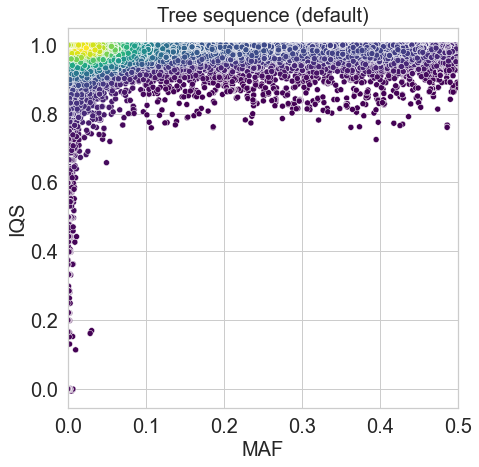

In [29]:
plot_results(df_ts_default, "Tree sequence (default)")

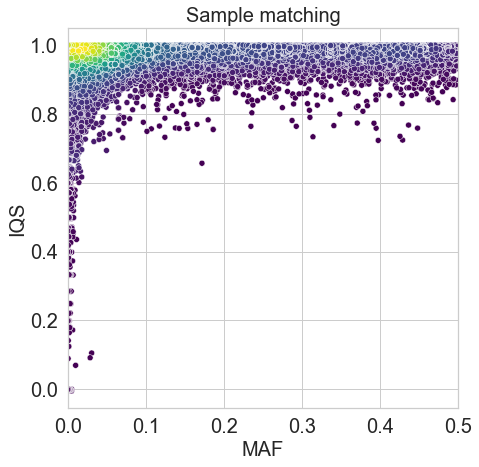

In [30]:
plot_results(df_samples_matched, "Sample matching")

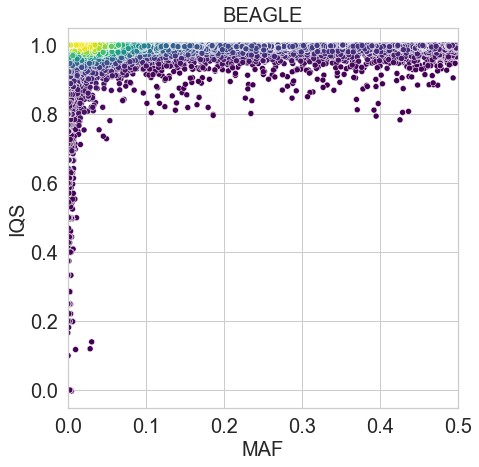

In [31]:
plot_results(df_beagle, "BEAGLE", "beagle.png")

In [17]:
min_iqs = 0.90

score_ts_default = np.sum(df_ts_default["iqs"] >= min_iqs) / float(df_ts_default.shape[0])
score_samples_matched = np.sum(df_samples_matched["iqs"] >= min_iqs) / float(df_samples_matched.shape[0])
score_beagle = np.sum(df_beagle["iqs"] >= min_iqs) / float(df_beagle.shape[0])

print(f"% sites with IQS >= {min_iqs}")
print(f"ts default: {score_ts_default}")
print(f"samples matched: {score_samples_matched}")
print(f"beagle: {score_beagle}")


% sites with IQS >= 0.9
ts default: 0.8471115663277727
samples matched: 0.8435015489493171
beagle: 0.9017235734134813
